# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* DPを**Howard's Improvement Algorithm （Policy Function Iteration）**で解く

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin, golden
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

### カリブレーション
* パラメータをひとつの変数にまとめる：classを使う

In [2]:
class Params:
    def __init__(self,β,γ,α,δ,nk,kmax,kmin,kgrid,maxit,tol):
        # パラメータ
        self.β = β         # 割引因子
        self.γ = γ         # 相対的危険回避度
        self.α = α         # 資本分配率 
        self.δ = δ         # 固定資本減耗
        
        # グリッド
        self.nk = nk       # 資本のグリッド数
        self.kmax = kmax   # 資本グリッドの最大値
        self.kmin = kmin   # 資本グリッドの最小値
        self.kgrid = kgrid # 資本グリッド

        # 繰り返し計算
        self.maxit = maxit # 繰り返し計算の最大値
        self.tol = tol     # 計算誤差の許容値(tolerance of error)

In [3]:
def calibration():

    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 101
    kmax = 0.5 # 固定資本減耗が0.08の場合、ここを10.0にする
    kmin = 0.05

    # numpyで等分グリッドを計算
    kgrid = np.linspace(kmin,kmax,nk)

    maxit = 1000
    tol = 1e-5 # 2.収束の基準を設定

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, maxit, tol)

In [4]:
params = calibration()

---

## 経済学でよく使う関数

In [5]:
import MyEconFcn

---

## 政策関数を当て推量
* アルゴリズム
    1. 適当に政策関数を当て推量する
    2. その政策関数を使い続けた場合の価値関数を計算する
        * 最適化のステップは不要
        * とりあえず1000回繰り返し計算をしておく
    3. 得られた価値関数の下での最適な政策関数を計算
    4. 得られた新しい政策関数を使って価値関数を計算し直す
        * 上記のステップ2と同じ
    5. 価値関数が収束するまで以上を繰り返す

In [7]:
# 政策関数の当て推量：総資源の半分を使い続ける
pfcn0 = 0.5*(params.kgrid**params.α + (1-params.δ)*params.kgrid)

In [8]:
def BellmanEq1(params,wealth,kprime,vnext):
    """
    ----------------------------------------------
    === k'を1つ与えた際にベルマン方程式の値を返す ===
    ----------------------------------------------
    <input>
    ・params: パラメータなどを含む構造体
    ・wealth: 今期利用可能な資産
    ・kprime: 次期の資本量
    ・vnext: スプライン補間した次期の価値関数
    <output>
    ・value: "正値のままの"ベルマン方程式
    """
    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    return value

In [11]:
vfcn0 = np.zeros(params.nk)
vfcn1 = np.zeros(params.nk)

# 利用可能な資産をあらかじめ計算しておく
wealth = params.kgrid**params.α + (1-params.δ)*params.kgrid

for j in range(1000):
    vnext = interp1d(params.kgrid,vfcn0,kind="cubic",fill_value="extrapolate")
    for i in range(params.nk):
        # ずっとpfcn0を使い続ける
        vfcn1[i] = BellmanEq1(params, wealth[i], pfcn0[i], vnext)

    vfcn0 = np.copy(vfcn1)

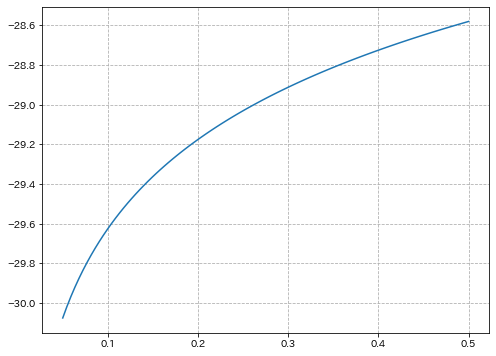

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,vfcn0)
ax.grid(ls="--")
plt.show()

In [16]:
def IterateValue(num_it,params,policy):
    """
    ----------------------------------------------
    === k'を1つ与えた際にベルマン方程式の値を返す ===
    ----------------------------------------------
    <input>
    ・num_it: 繰り返し計算の回数
    ・params: パラメータなどを含む構造体
    ・policy: 所与の政策関数
    <output>
    ・vfcn0: 任意の政策関数を使い続けた際の価値関数
    """

    vfcn0 = np.zeros(params.nk)
    vfcn1 = np.zeros(params.nk)
    wealth = params.kgrid**params.α + (1-params.δ)*params.kgrid # 関数の外に出したほうが計算速度はアップ

    for j in range(num_it):
        vnext = interp1d(params.kgrid,vfcn0,kind="cubic",fill_value="extrapolate")
        for i in range(params.nk):
            # ずっと同じpolicyを使い続ける
            vfcn1[i] = BellmanEq1(params, wealth[i], policy[i], vnext)    
        vfcn0 = np.copy(vfcn1)
    
    return vfcn0

In [17]:
vfcn0 = IterateValue(1000, params, pfcn0);

---

## 最適化によって政策関数をアップデート

In [19]:
def BellmanEq2(params,wealth,kprime,vnext):
    """
    ----------------------------------------------
    === k'を1つ与えた際にベルマン方程式の値を返す ===
    ----------------------------------------------
    <input>
    ・params: パラメータなどを含む構造体
    ・wealth: 今期利用可能な資産
    ・kprime: 次期の資本量
    ・vnext: スプライン補間した次期の価値関数
    <output>
    ・value: 負値にしたベルマン方程式
    """
    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    value = -1*value
    
    return value

In [25]:
# 再計算
pfcn0 = 0.5*(params.kgrid**params.α + (1-params.δ)*params.kgrid)
pfcn1 = np.zeros(params.nk)
vfcn0 = IterateValue(1000, params, pfcn0)
vfcn1 = np.zeros(params.nk)

In [36]:
# 価値関数を繰り返し計算
for it in range(params.maxit):

    # 次期の価値関数を補間
    vnext = interp1d(params.kgrid,vfcn0,kind="cubic",fill_value="extrapolate") # スプライン補間

    for i in range(params.nk):

        BellmanEq = lambda kprime: BellmanEq2(params, wealth[i], kprime, vnext)
        pfcn1[i] = golden(BellmanEq,brack=(0.0,wealth[i]-1e-10)) # 最適化
    
    # 新たな政策関数を使って価値関数をアップデート
    vfcn1 = IterateValue(1000, params, pfcn1)

    dif1 = np.max(np.abs((vfcn1 - vfcn0)/vfcn0)) # 価値関数の繰り返し計算誤差
    dif2 = np.max(np.abs((pfcn1 - pfcn0)/pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

    vfcn0 = np.copy(vfcn1)
    pfcn0 = np.copy(pfcn1)

    print(f"iteration counter: {it+1}")
    print(f"error (value): {dif1:.6f}")
    print(f"error (policy): {dif2:.6f}")
    print("")

    if dif1 < params.tol:
        break

    if it == params.maxit-1:
        print("The model does not converge...")

iteration counter: 1
error (value): 0.000000
error (policy): 0.232001



---

## PFI
* 上記の説明をまとめて関数化

In [37]:
# 政策関数の当て推量
pfcn0 = 0.5*(params.kgrid**params.α + (1-params.δ)*params.kgrid)

# 当て推量の下での価値関数
vfcn0 = IterateValue(1000, params, pfcn0)

# 価値関数・政策関数を初期化
pfcn1 = np.zeros(params.nk)
vfcn1 = np.zeros(params.nk)

In [40]:
def pfi(params):
    """
    ----------------------------------------------------------------------------------------
    === 状態変数のみ離散化して操作変数は連続的に値を取る場合の動的計画法(parametric DP)の解法. ===
        アルゴリズムの詳細は、Johnson et al. (1993)を参照
    ----------------------------------------------------------------------------------------
    <input>
    ・params: パラメータ等を含む構造体
    <output>
    ・vfcn0: 計算によって得られた価値関数
    ・pfcn0: 計算によって得られた政策関数
    """

    # 政策関数の当て推量
    pfcn0 = 0.5*(params.kgrid**params.α + (1-params.δ)*params.kgrid)

    # 当て推量の下での価値関数
    vfcn0 = IterateValue(1000, params, pfcn0)

    # 価値関数・政策関数を初期化
    pfcn1 = np.zeros(params.nk)
    vfcn1 = np.zeros(params.nk)

    # 価値関数を繰り返し計算
    for it in range(params.maxit):

        # 次期の価値関数を補間
        vnext = interp1d(params.kgrid,vfcn0,kind="cubic",fill_value="extrapolate") # スプライン補間

        for i in range(params.nk):

            BellmanEq = lambda kprime: BellmanEq2(params, wealth[i], kprime, vnext)
            pfcn1[i] = golden(BellmanEq,brack=(0.0,wealth[i]-1e-10)) # 最適化
    
        # 新たな政策関数を使って価値関数をアップデート
        vfcn1 = IterateValue(1000, params, pfcn1)

        dif1 = np.max(np.abs((vfcn1 - vfcn0)/vfcn0)) # 価値関数の繰り返し計算誤差
        dif2 = np.max(np.abs((pfcn1 - pfcn0)/pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

        vfcn0 = np.copy(vfcn1)
        pfcn0 = np.copy(pfcn1)

        print(f"iteration counter: {it+1}")
        print(f"error (value): {dif1:.17f}")
        print(f"error (policy): {dif2:.17f}")
        print("")

        if dif1 < params.tol:
            break

        if it == params.maxit-1:
            print("The model does not converge...")
    
    return vfcn0, pfcn0

#### 計算結果
* もともと計算時間はそんなにかかっていなかったが、VFIより計算速度がアップしている
* なにより、繰り返し計算が2回に短縮している

In [41]:
start = time.time()
vfcn0, pfcn0 = pfi(params)
end = time.time()

print(f"{end-start:.6f} seconds")

iteration counter: 1
error (value): 0.03856478820076882
error (policy): 0.23200083684732509

iteration counter: 2
error (value): 0.00000000000000205
error (policy): 0.00000023401030520

4.092255 seconds


---

In [42]:
# 最終的な政策関数が得られてから消費関数を計算
wealth = params.kgrid**params.α + (1-params.δ)*params.kgrid
cfcn = wealth - pfcn0

In [43]:
# 政策関数を使って収束した価値関数を計算
util = np.zeros(params.nk)
valfn = np.zeros(params.nk)

for i in range(params.nk):

    cons = params.kgrid[i]**params.α + (1-params.δ)*params.kgrid[i] - pfcn0[i]
    util[i] = MyEconFcn.crra(cons, params.γ)
    valfn[i] = util[i] / (1-params.β)

In [44]:
# 解析解
AA = (1-params.β)**(-1) * (np.log(1-params.α*params.β) + ((params.α*params.β)/(1-params.α*params.β))*np.log(params.α*params.β))
BB = params.α / (1 - params.α*params.β)
v_true = AA+ BB*np.log(params.kgrid)
p_true = params.α*params.β*(params.kgrid**params.α);

---

# プロット

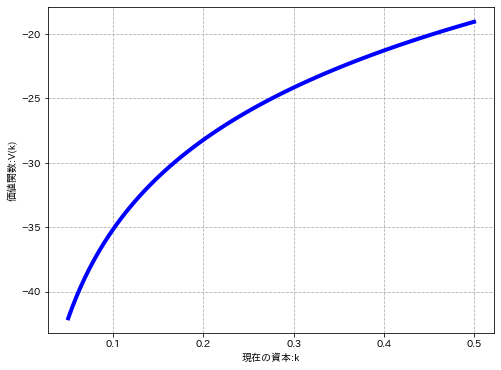

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,valfn,c="b",lw=4)
ax.set(xlabel="現在の資本:k",ylabel="価値関数:V(k)")
ax.grid(ls="--")
plt.show()

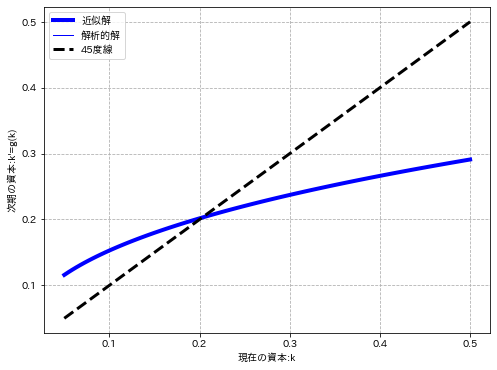

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,pfcn0,c="b",lw=4,label="近似解")
ax.plot(params.kgrid,p_true,c="b",lw=1,label="解析的解")
ax.plot(params.kgrid,params.kgrid,ls="--",c="k",lw=3,label="45度線")
ax.set(xlabel="現在の資本:k",ylabel="次期の資本:k'=g(k)")
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* グリッドを増やして、VFIとPFIの速度比較をしてみよう。